# IS-02 Machine Learning - Data and Web Science
## Final Project
## Problem 1 - Unlabeled Clustering
### <i>Avgitidis Konstantinos </i>

In [1]:
#importing necessary libraries
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, SpectralClustering

<p style='text-align: justify;'> The given problem requires us to train an algorithm with some unlabeled data and predict
the values of labeled data. This seems to be a case of a clustering problem so we should first
take a look into our data and find out which kind of clustering algorithms we're going to be using.
In general we can categorize clustering algorithms in two categories:
Hard Clustering, where each data point either belongs entirely to a cluster or not.
Soft Clustering, where instead of placing each data point in a separate cluster, the probability or probability of the data point being in these groups is assigned. </p>

In [2]:
#Loading our data
X_train = pd.read_csv('NSL-KDDTrain.csv')
X_test = pd.read_csv('NSL-KDDTest.csv')

In [3]:
X_train.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,udp,other,SF,146,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,tcp,private,S0,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,tcp,http,SF,232,8153,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [4]:
X_test.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,attack
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,attack
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,attack
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,attack


Alright, we can clearly see that the test dataset contains one more column called "target" which must
contain the type of communication (normal or attack). We can confirm that by running the following code:

In [5]:
X_test.target.value_counts()

attack    12833
normal     9711
Name: target, dtype: int64

So it appears that we have more attacks than normal communications. If we consider that the test dataset is a
representative subset of an original dataset that contains both (train + test), we can imply that we have
more attacks than normal communications in this Dataset. We will use that logic later on.

Moving on lets look if we have any NaN values in our data.

In [6]:
#Check how many NaN values we got
print(sum(X_train.isnull().sum()))

0


No NaN values so there is no need for further processing.

Now lets see the types of our train dataset.

In [7]:
X_train.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

Ok since we are dealing with a clustering problem, we will use one-hot encoding to remove
all categorical (object) values of the dataset.
Doing that we also have to include only the columns included in the test subset, after the
encoding.

In [8]:
#One-hot encoding for categorical values
X_train = pd.get_dummies(X_train,columns=['protocol_type','service','flag'])
X_test = pd.get_dummies(X_test,columns=['protocol_type','service','flag'])
# X_train.drop(axis=1,columns=['protocol_type','service','flag'],inplace=True)
# X_test.drop(axis=1,columns=['protocol_type','service','flag'],inplace=True)

In [9]:
Xtarget = X_test.target #Lets put that away for later use
X_test.drop(axis=1, columns='target', inplace = True)

In [10]:
#keep only the columns present in the test dataset
X_train = X_train[X_test.columns]

We should also scale our data using Standard Scaler (or any scaler) since it is proven that most
algorithms run better on scaled data.

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values)
X_test = scaler.transform(X_test.values)

In [12]:
X_train.shape[1] #number of columns/features

116

<p style='text-align: justify;'> At this point we can see that we have too many features so we need to cut some of them down in
order to help our algorithms run better. The method of choice is PCA.Principal Component Analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set. Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process. Also by doing that we can generalize our models even more. </p>

In [13]:
#use PCA to cut down features to 20
pca = PCA(n_components=20,svd_solver="full")
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

The three Algorithms we chose are KMeans, MiniBatchKMeans and Birch. The main reason for choosing them is the inclusion of the n_clusters parameter. Since the number for clusters is known to us we can take advantage of it and train the algorithms using n_clusters = 2. Apart from the 3 different algorithms chosen we conducted four experiments for each algorithm for a total of 12 experiments.

In [14]:
# define the models
models = [KMeans(n_clusters=2,n_init=100,init="k-means++",max_iter=1000000,algorithm="elkan"),
          KMeans(n_clusters=2,n_init=100,init="k-means++",max_iter=1000000,algorithm="full"),
          KMeans(n_clusters=2,n_init=100,init="random",max_iter=1000000,algorithm="elkan"),
          KMeans(n_clusters=2,n_init=100,init="random",max_iter=1000000,algorithm="full"),
          MiniBatchKMeans(n_clusters=2,init="k-means++",max_iter=1000000,batch_size=100),
          MiniBatchKMeans(n_clusters=2,init="k-means++",max_iter=1000000,batch_size=1000),
          MiniBatchKMeans(n_clusters=2,init="random",max_iter=1000000,batch_size=100),
          MiniBatchKMeans(n_clusters=2,init="random",max_iter=1000000,batch_size=1000),
          Birch(threshold=0.5,n_clusters=2),
          Birch(threshold=0.7,n_clusters=2),
          Birch(threshold=0.3,branching_factor=100,n_clusters=2),
          Birch(threshold=0.4,branching_factor=50,n_clusters=2)]

<p style='text-align: justify;'> Like stated above, the number of attacks is bigger than the number of normal transactions, so we can make the assumption that this happens on the test dataset as well. After trainining each clustering model, the highest of 1 or 0 (2 Clusters) will be considered as an attack and the lowest as a normal transaction. Doing that for each model enables us also to map the Test's dataset target column, according to the results extracted before. We then calculate the Silhouette score and the accuracy of each model by running it on the Test dataset. The results of our experiments are shown below. </p>

In [15]:
algs = []
# assign each data point to a cluster
try:
    algs = pickle.load( open( "cluster.p", "rb" ) )
    for alg in algs:
        print(f'Algorithm with parameters: {alg[0]}, Accuracy = {alg[1]}, Silhouette Coefficient: {alg[2]}')
except FileNotFoundError:
    for model in models:
        train_results = model.fit_predict(X_train)
        if list(train_results).count(0) > list(train_results).count(1):
            Y_test = [1 if i == 'normal' else 0 for i in Xtarget.values]
        else:
            Y_test = [0 if i == 'normal' else 1 for i in Xtarget.values]
        Y_pred = model.predict(X_test)
        results = [1 if i==j else 0 for i,j in zip(Y_test,Y_pred)]
        accuracy = results.count(1)/len(results)
        silhouette_score = metrics.silhouette_score(X_test, Y_pred)
        algs.append((model,accuracy,silhouette_score))
        print(f'Algorithm with parameters: {str(model)}, Accuracy = {accuracy}, Silhouette Coefficient: {silhouette_score}')
    pickle.dump(algs, open( "cluster.p", "wb" ) )

Algorithm with parameters: KMeans(algorithm='elkan', max_iter=1000000, n_clusters=2, n_init=100), Accuracy = 0.26534776437189495, Silhouette Coefficient: 0.310657850773387
Algorithm with parameters: KMeans(algorithm='full', max_iter=1000000, n_clusters=2, n_init=100), Accuracy = 0.26539212207239177, Silhouette Coefficient: 0.310651977848498
Algorithm with parameters: KMeans(algorithm='elkan', init='random', max_iter=1000000, n_clusters=2,
       n_init=100), Accuracy = 0.26534776437189495, Silhouette Coefficient: 0.310657850773387
Algorithm with parameters: KMeans(algorithm='full', init='random', max_iter=1000000, n_clusters=2,
       n_init=100), Accuracy = 0.26534776437189495, Silhouette Coefficient: 0.310657850773387
Algorithm with parameters: MiniBatchKMeans(max_iter=1000000, n_clusters=2), Accuracy = 0.5724361249112846, Silhouette Coefficient: 0.18028183532440864
Algorithm with parameters: MiniBatchKMeans(batch_size=1000, max_iter=1000000, n_clusters=2), Accuracy = 0.3392476933995

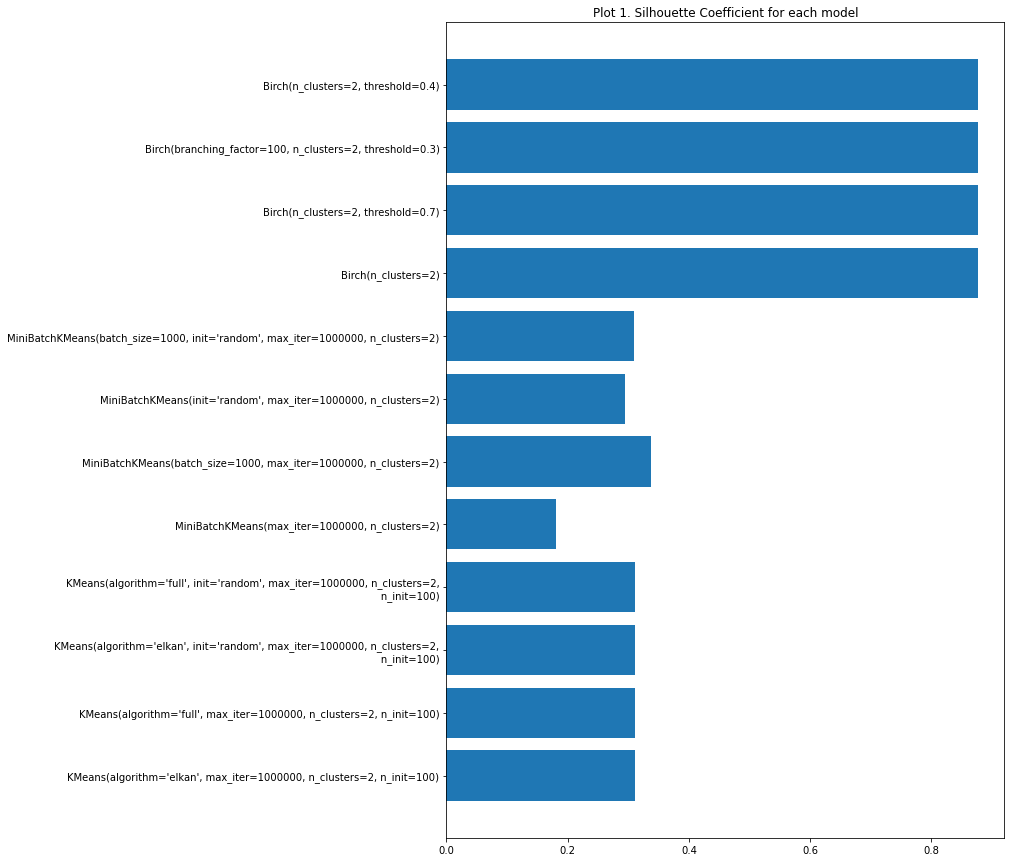

In [16]:
#show the results into a horizontal barplot
fig, ax = plt.subplots(figsize=(10,15))
columns = [str(i[0]) for i in algs]
slh = [i[2] for i in algs]
plt.barh(columns,slh)
plt.title("Plot 1. Silhouette Coefficient for each model")
plt.show()

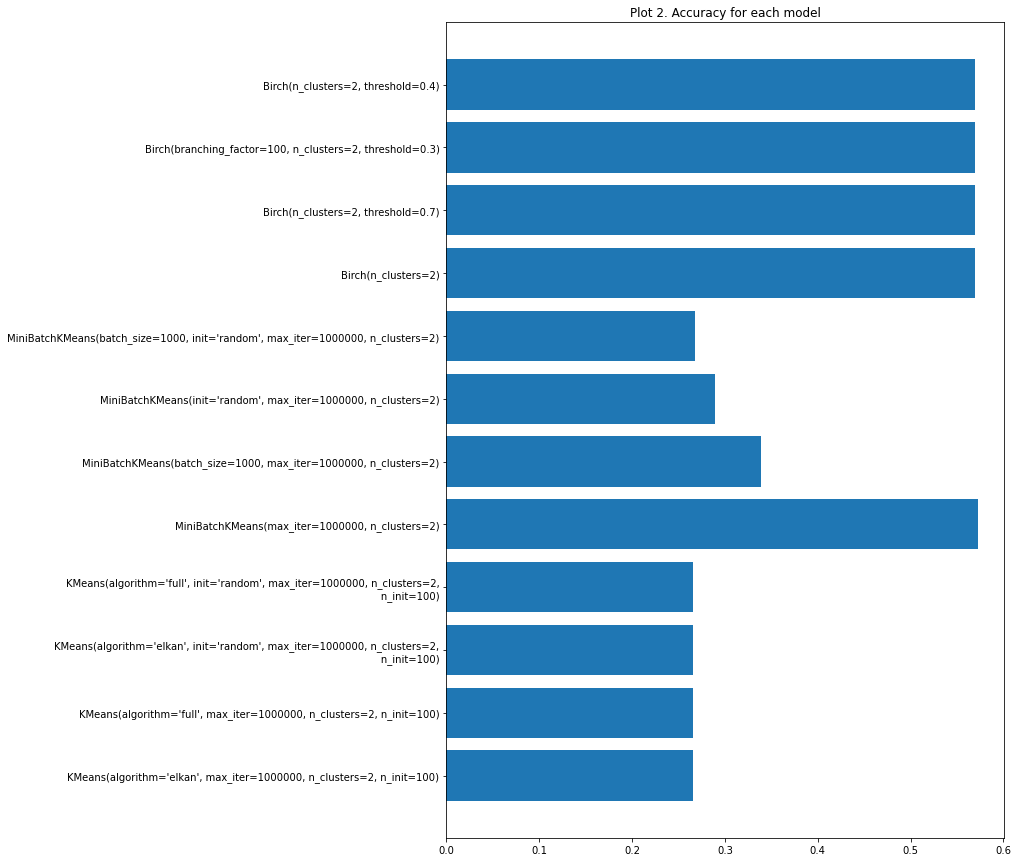

In [17]:
fig, ax = plt.subplots(figsize=(10,15))
acc = [i[1] for i in algs]
plt.barh(columns,acc)
plt.title("Plot 2. Accuracy for each model")
plt.show()

<p style='text-align: justify;'> In Plot 2 we can see clearly that the Birch models along with one of the MiniBatchKmeans models have the best accuracy compared to the other models. Using the same graph as a reference point, we can observe that changing parameters on the Birch and KMeans models has no impact on the accuracy when we ran it on the Test dataset. The only model that produces different results when we change it's parameters is the MiniBatchKMeans. From Plot 1 we can clearly see that the best Silhouette Coefficient is that of the Birch models. Using our previous observations we can come to the conclusion that the best model, for our particular case, is any of the Birch models. </p>